In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]



mean = cards_to_age["age"].mean()
threshold = .005+(mean/2000)
shuffle_role = random.random()
print(f"{shuffle_role=:.6f}; {threshold=:.6f}")
if shuffle_role < threshold:
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications 
priority_headers = [
    "Django", 
    "CCH Tax Forms Project",
    "Microsoft Purview"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.0718
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

shuffle_role=0.205049; threshold=0.019772


In [3]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Ansible,205.545200,5.138630,13.837234,40
ODBC,117.516738,7.344796,47.197238,16
Network Terms,155.443161,10.362877,43.713797,15
"Everything is Tuberculosis, Green",275.818112,11.992092,49.541675,23
Exchange Online and Defender,899.024833,13.621588,177.125528,66
"The Mines of the Behemoth, Shea",990.301487,20.210234,147.019416,49
eDiscovery,1138.700708,21.484919,149.112572,53
Python,1149.300763,22.986015,161.124635,50
Ubuntu,598.127581,23.004907,137.628909,26
WinHex,464.567066,23.228353,142.119184,20


# Histogram

sum of ages: ~24200.73


<Axes: >

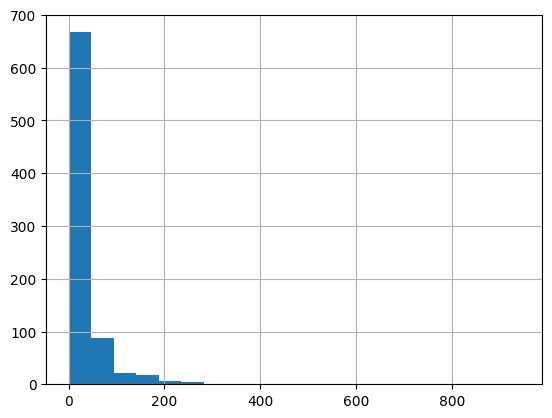

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~24200.73


<Axes: >

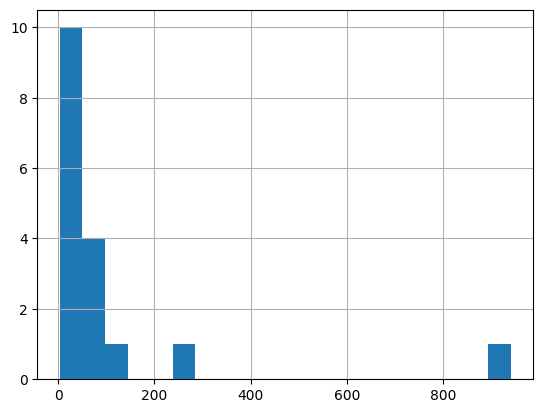

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='CCH Tax Forms Project']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [ ]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

Cards found: 809
Total card age: 24200.73


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
28,CCH Tax Forms Project,Disabling GenerateMeta in CCH Axcess export op...,0881e21379d3a9f0ad63b7c4f20a58f9,940.995023,103.840015,940.995023,1765.280262,0.765351,17
91,Terraform Codebox,Terraform modules allow you to organize and re...,30dc7c65ccaa1883bdec852a7b452264,755.931315,54.374907,755.931315,1631.247211,0.063682,30
140,Microsoft Purview,Related to business domains are data products....,5989fb1bcb3a2780f5f0720e9aef312a,376.918566,49.308977,376.918566,1775.123166,0.022973,36
119,Node.js and Vite,"""Failed to resolve import '@/components/ui/car...",556e229bc8e0e216c20cce4c223cef76,313.209526,53.384619,313.209526,1708.307823,0.005341,32
133,JavaScript Concepts,"For objects, by default String returns an unhe...",cc7c3bc61969fcf92a11320dd7feed10,280.772338,45.286506,280.772338,1494.454695,0.335906,33
141,Microsoft Purview,Steps to create a DLP policy\n Choose what ...,4f0b5e031371a6388fc727c4144921c5,260.731045,49.308977,376.918566,1775.123166,0.022973,36
29,CCH Tax Forms Project,Calling elem.clear() in Python’s ElementTree f...,29f39569d5ccccfb3ed756311cc7b22d,256.116352,103.840015,940.995023,1765.280262,0.765351,17
134,JavaScript Concepts,"In many cases, it makes sense to assign a more...",a7297b840cb42c00f43f99692be05833,254.065579,45.286506,280.772338,1494.454695,0.335906,33
120,Node.js and Vite,Preflight Checks (shadcn)\nshadcn’s built-in v...,4bb54314dbd00471f39cec846bc1cfe2,249.598234,53.384619,313.209526,1708.307823,0.005341,32
98,Active Directory and Azure Files,Access Control Entry (ACE)\nAn individual line...,7c3aca1e0d5e7e16524bf00593c3c22f,230.878870,46.604099,230.878870,1398.122971,0.406560,30


# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [ ]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

## Age Max

In [10]:
# n = random.choice([2, 3, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=existing_cards.shape[0]//100
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(3919.216848871412)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
28,CCH Tax Forms Project,Disabling GenerateMeta in CCH Axcess export op...,0881e21379d3a9f0ad63b7c4f20a58f9,940.995023,103.840015,940.995023,1765.280262,0.765351,17
91,Terraform Codebox,Terraform modules allow you to organize and re...,30dc7c65ccaa1883bdec852a7b452264,755.931315,54.374907,755.931315,1631.247211,0.063682,30
140,Microsoft Purview,Related to business domains are data products....,5989fb1bcb3a2780f5f0720e9aef312a,376.918566,49.308977,376.918566,1775.123166,0.022973,36
119,Node.js and Vite,"""Failed to resolve import '@/components/ui/car...",556e229bc8e0e216c20cce4c223cef76,313.209526,53.384619,313.209526,1708.307823,0.005341,32
133,JavaScript Concepts,"For objects, by default String returns an unhe...",cc7c3bc61969fcf92a11320dd7feed10,280.772338,45.286506,280.772338,1494.454695,0.335906,33
141,Microsoft Purview,Steps to create a DLP policy\n Choose what ...,4f0b5e031371a6388fc727c4144921c5,260.731045,49.308977,376.918566,1775.123166,0.022973,36
29,CCH Tax Forms Project,Calling elem.clear() in Python’s ElementTree f...,29f39569d5ccccfb3ed756311cc7b22d,256.116352,103.840015,940.995023,1765.280262,0.765351,17
134,JavaScript Concepts,"In many cases, it makes sense to assign a more...",a7297b840cb42c00f43f99692be05833,254.065579,45.286506,280.772338,1494.454695,0.335906,33
120,Node.js and Vite,Preflight Checks (shadcn)\nshadcn’s built-in v...,4bb54314dbd00471f39cec846bc1cfe2,249.598234,53.384619,313.209526,1708.307823,0.005341,32
98,Active Directory and Azure Files,Access Control Entry (ACE)\nAn individual line...,7c3aca1e0d5e7e16524bf00593c3c22f,230.878870,46.604099,230.878870,1398.122971,0.406560,30


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 29.914'